Example of running hierarchical Bayesian inference with the code:

We consider a single mass, limepy model with $(g,\Phi_0,\log_{10}M,r_h)=(2,5,5,3)$. We samples 100 points from the DF in Cartesian coordinates and then convert to sky coordinates, and add Gaussian measurement errors with $\sigma_{\alpha}=\sigma_{\delta}=\sigma_{\pi}=0.1$ mas for angular posoitions, and $\sigma_{\mu_{\alpha*}}=\sigma_{\mu_{\delta}}=0.1$ mas/year for proper motions. We assume stars' velocity is completely unknown (Gaia data). 

The cluster center is given as
\begin{align}
  \boldsymbol{\theta}_{c}&=(\boldsymbol{q}_{\rm c},\boldsymbol{p}_{\rm c})=(\alpha_{\rm c},\delta_{\rm c},\pi_{\rm c},\mu_{\alpha*,{\rm c}},\mu_{\delta,{\rm c}},v_{R,{\rm c}})\nonumber\\
    &=(\frac{\pi}{3} {\, \rm rad},\frac{\pi}{4} {\,\rm rad}, 1{\,\rm mas},4 {\,\rm mas/year}, 5 {\,\rm mas/year}, 30 {\,\rm km/s})
\end{align}

We first generate the simulated data, and then fit the hierarchical Bayesain model:

In [1]:
import numpy as np
from math import pi
from simulate_limepy_sky import simulate_limepy
from HBI_limepy import Bayesian_sampling
import gc

#W，g, log10M, rh
ip = [5.0,2.0,np.log10(1e5),3.0]
#a,d,R,vx,vy,vz
ic = [pi/3,pi/4,1000,4,5,30]
#a,d,p (mas),va,vd (mas/year)
error_sd = np.transpose(np.array([[0.1, 0.1, 0.1, 0.1, 0.1, 0]]))


def simulate_fit(index,seed_error,seed_limepy,\
                 ip=ip,ic=ic,error_sd=error_sd,\
                 ndraws=1000,nburns=1000,chains=4,target_accept=0.8):
    #generated simulated data
    sky_c,truex,truev,datax,datav= simulate_limepy(ip,ic,Np=1000,data_type='ski',\
                    include_error=True,error=error_sd,seed_limepy=seed_limepy,seed_error=seed_error)
    #precompile data (does not matter)
    xhhh = np.concatenate([np.array(ip[:3]),np.log10(np.array([ip[3]])),sky_c,\
                           truex[0],truex[1],(1000/truex[2]-1000/sky_c[2]),\
                           truev[0],truev[1],(truev[2]-sky_c[5])])
    #create sampling class
    B_S = Bayesian_sampling(datax,datav[:2,:],xhhh,data_type='ski',error_obs=error_sd)
    idata = B_S.sampling(ndraws=ndraws,nburns=nburns,chains=chains,target_accept=target_accept)
    return idata

np.random.seed(1)
random_array = np.random.randint(low=0, high=10000, size=(1000,2))
index = 100 #an index for choosing random seed for measurement errors and limepy simulations.
seed_error, seed_limepy = random_array[index,0],random_array[index,1]
#simulate and fit
idata = simulate_fit(index,seed_error,seed_limepy,ndraws=2000,nburns=3000,chains=3,target_accept=0.8)

6244.261150394046
[-5.43668810e+00 -1.05663372e+01 -8.08146921e+01 ...  2.14014597e-02
  1.00163132e-01 -2.72868009e-01]


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Phi0, g, log10M, log10rh, ac, dc, pc, vac, vdc, vRc, a, d, Rtc, va, vd, vRtc]
INFO:pymc:NUTS: [Phi0, g, log10M, log10rh, ac, dc, pc, vac, vdc, vRc, a, d, Rtc, va, vd, vRtc]


Sampling 3 chains for 3_000 tune and 2_000 draw iterations (9_000 + 6_000 draws total) took 7888 seconds.
INFO:pymc:Sampling 3 chains for 3_000 tune and 2_000 draw iterations (9_000 + 6_000 draws total) took 7888 seconds.
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc:The chain contains only diverging samples. The model is probably misspecified.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9827, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

It is better to run the inference on computer clusters. For 1000 stars, it will take an hour.

Removed no burn in


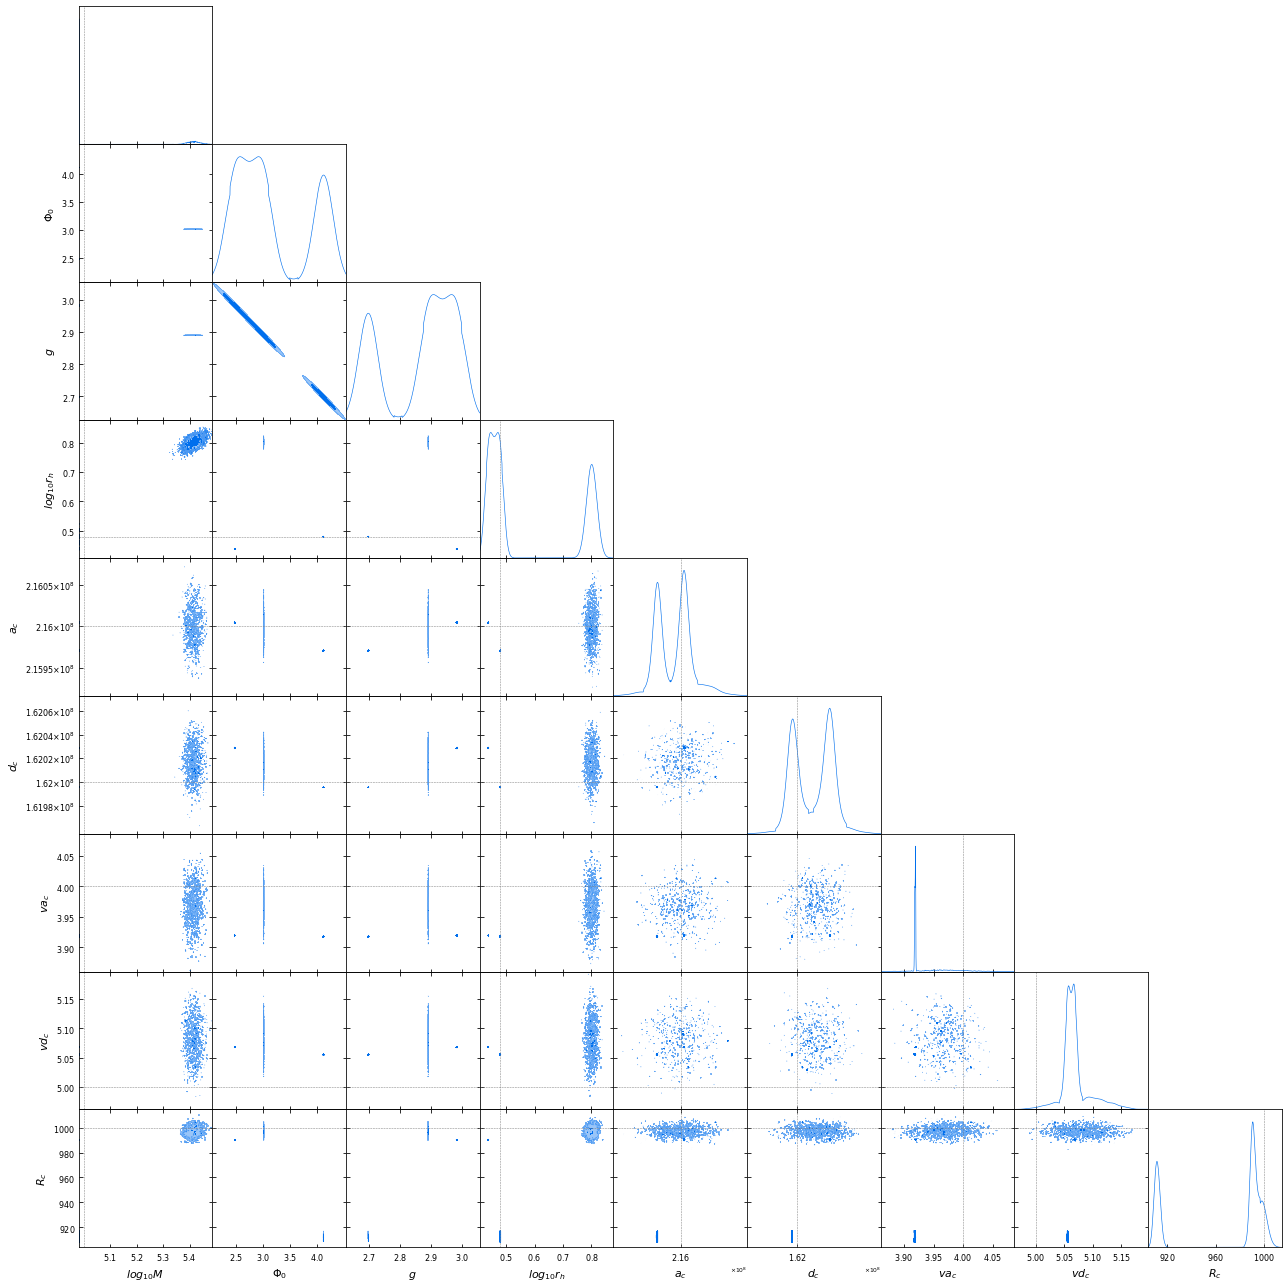

In [13]:
from jax import numpy as jnp
import jax
from coordinate_transform_jax import StC, CtS
def sky_center(ip,ic):
    rad_to_mas = 180/pi*60*60*10**3
    center_param = ic
    ac = center_param[0]*rad_to_mas
    dc = center_param[1]*rad_to_mas
    pc = 1000/center_param[2]
    po_c = StC(jnp.array([ac,dc,pc,ic[3],ic[4],ic[5]]))
    phase_car_c = np.array([po_c[0],po_c[1],po_c[2],center_param[3],center_param[4],center_param[5]])
    sky_c = np.array(CtS(jnp.array(phase_car_c)))
    return sky_c


#convert to numpy
stacked = idata.posterior
data_t = np.stack([stacked.log10M.values,stacked.Phi0.values,stacked.g.values,stacked.log10rh.values,\
                    stacked.ac.values,stacked.dc.values,stacked.vac.values,stacked.vdc.values,1000/stacked.pc.values])


from getdist import plots, MCSamples

sky_c = sky_center(ip,ic)
#data_t =np.loadtxt('./data_fit/s%d%d%d%d/s%d%d%d%d-%d.txt' %(ip[0],ip[1],ip[3],ip[2],ip[0],ip[1],ip[3],ip[2],index))

names = ["log10M","Phi0","g","log10rh","ac","dc","vac","vdc","Rc"]
labels =  ["log_{10}M","\Phi_0","g","log_{10}r_h","a_c","d_c","va_c","vd_c","R_c"]
samples = MCSamples(samples=np.transpose(data_t),names = names, labels = labels)

g = plots.get_subplot_plotter()
g.triangle_plot([samples],filled=True,markers={"g": ip[1], "Phi0": ip[0], "log10M": ip[2], "log10rh": np.log10(ip[3]),\
                                                "ac":sky_c[0],"dc":sky_c[1],\
                                               "vac":ic[3], "vdc":ic[4],"Rc":1000/sky_c[2]})

In [10]:
sky_c[3]

-0.2033767793107769

Plot the inference results for the structual parameters and cluster centers:

In [11]:
ic[3]

4